<a href="https://colab.research.google.com/github/kevin9549/github-final-project/blob/main/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dalam proyek ini, saya akan menggunakan Convolutional Neural Network untuk membangun, melatih, dan menguji model klasifikasi rambu lalu lintas. Kami akan membangun model ini menggunakan TensorFlow dan Keras. Ini adalah masalah klasifikasi multikelas. Model ini dapat digunakan untuk membuat mobil yang lebih cerdas.








In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinbintang9549","key":"4e44e61c36a21e101a021ce0d9e7e1cf"}'}

dimulai dengan menghubungkan ke Kaggle menggunakan Kaggle API

In [ ]:
!pip install -q kaggle

Install kaggle api meggunakan pip

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Mengatur Kaggle menggunakan Kaggle API.








In [ ]:
# Creating directory and changing the current working directory
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


Untuk menyimpan data, saya akan membuat direktori baru dan menjadikannya sebagai direktori kerja saat ini.

In [ ]:
# Downloading dataset and coming out of directory
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 99% 603M/612M [00:02<00:00, 247MB/s]
100% 612M/612M [00:02<00:00, 225MB/s]
/content


Setelah mencari data, langkah selanjutnya adalah mengunduh data ke notebook Colab.








In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: traffic_sign_dataset/train/5/00005_00053_00010.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00011.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00012.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00013.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00014.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00015.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00016.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00017.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00018.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00019.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00020.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00021.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00022.png  
  inflating: traffic_sign_dataset/train/5/00005_00053_00023.png  
  inflating: traf

mengekstrak data yang telah diunduh dan menghapus file-file yang tidak relevan.








In [ ]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

melakukan Import library yang dibutuhkan.

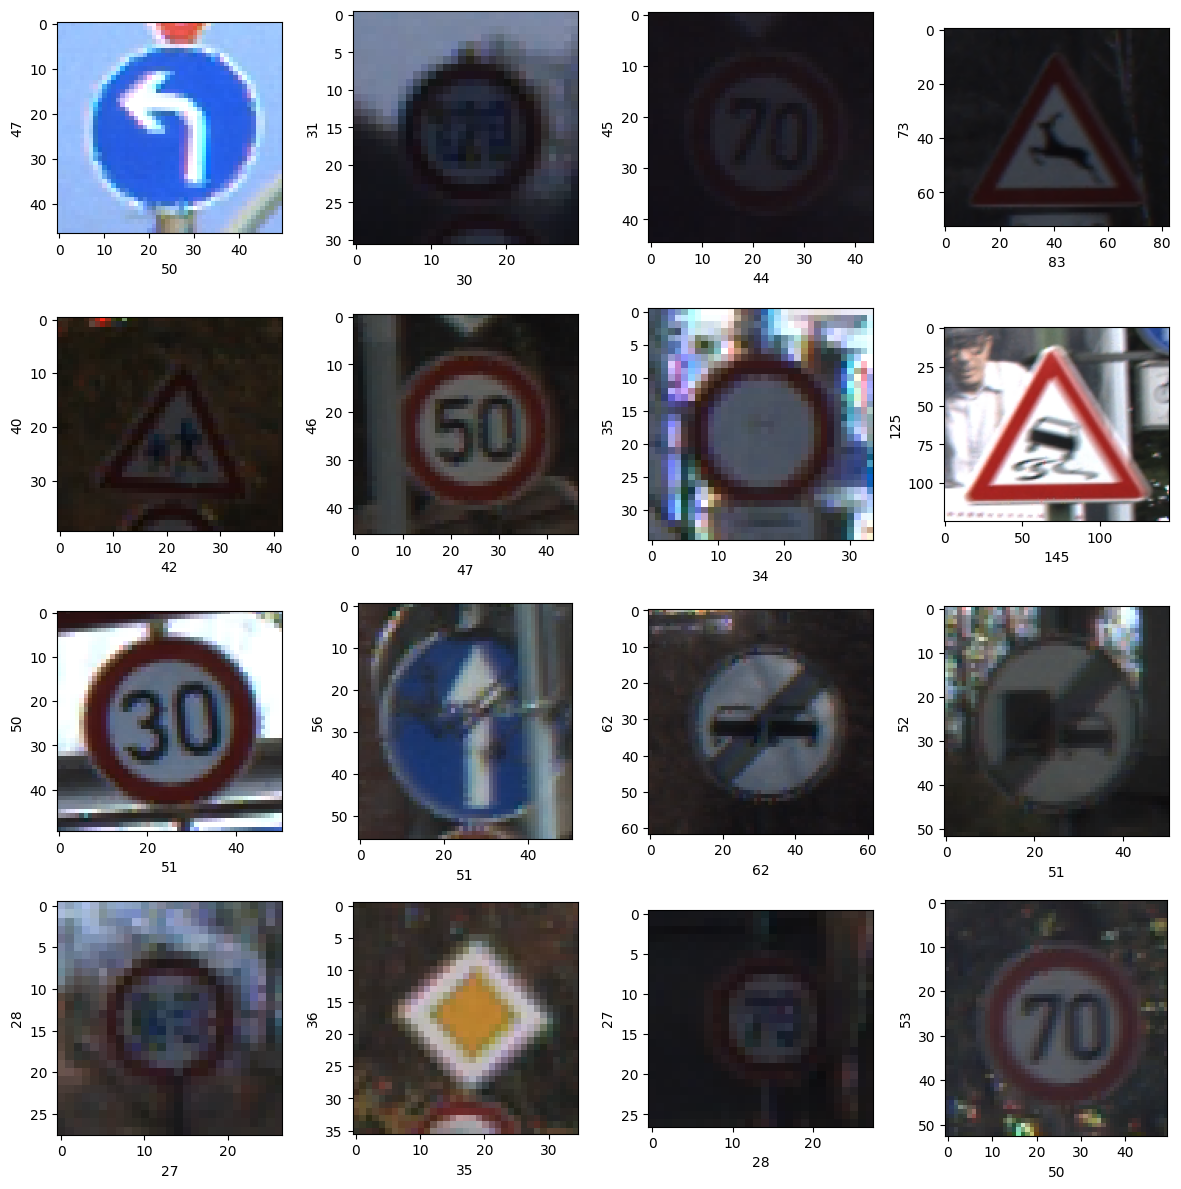

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

Melakukan visualisasi beberapa gambar tanda lalu lintas dari dataset uji. Kita dapat melihat bahwa dimensi gambar-gambar tersebut tidak seragam.








In [ ]:
# As size of images are different we have to make them equal so we will take mean of dimanesions
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

Untuk pemrosesan lebih lanjut, kita memerlukan gambar dengan dimensi yang seragam. Jadi, kita akan mulai dengan menyimpan dimensi dari semua gambar di dataset pelatihan dari ke-43 kelas.

In [ ]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


Sekarang, saya akan mencari nilai rata-rata dari kedua dimensi tersebut dan menganalisisnya. Di sini, dapat dilihat bahwa (50,50) adalah bentuk rata-rata untuk semua gambar.








In [ ]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

Sekarang, saya akan mengubah ukuran gambar menjadi (50,50) dan juga menyimpan ID labelnya.








In [ ]:
#Converting images into numpy array
images = np.array(images)
#The pixel value of each image ranges between 0 and 255
#Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
images = images/255

Sekarang, saya akan mengubah semua gambar menjadi array numpy dan menormalisasi nilai-nilainya.








In [ ]:
label_id = np.array(label_id)
label_id.shape

(39209,)

Menyimpan ID label ke dalam array numpy dan mencetak bentuknya. Di sini, kita dapat mengamati bahwa ada 39.209 ID label.








In [ ]:
images.shape

(39209, 50, 50, 3)

Memeriksa bentuk gambar. Di sini, kita dapat melihat bahwa ada 39.209 gambar dengan bentuk (50, 50, 3).








In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

,count
0,
2,2250
1,2220
13,2160
12,2100
38,2070


Sekarang kita akan mengamati jumlah gambar per kelas untuk memeriksa apakah data seimbang atau tidak. Dari hasil yang didapat, kita dapat menyimpulkan bahwa data ini seimbang.








In [ ]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

Langkah selanjutnya adalah membagi data menjadi data pelatihan dan validasi, dengan 80% untuk data pelatihan dan 20% untuk data validasi.








In [ ]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

Mengonversi kolom kelas menjadi kategorikal menggunakan fungsi to_categorical().








In [ ]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

Mendefinisikan arsitektur model. Pada langkah ini, kita akan mendefinisikan semua lapisan dengan ukuran input, ukuran kernel, aktivasi, dan lainnya.








In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

Menyusun model menggunakan metrik, optimisasi, dan fungsi kerugian yang diperlukan serta mencetak ringkasan model.








In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 181s - loss: 2.4905 - accuracy: 0.3134 - val_loss: 1.2485 - val_accuracy: 0.6646 - 181s/epoch - 735ms/step
Epoch 2/10
246/246 - 177s - loss: 1.1839 - accuracy: 0.6312 - val_loss: 0.4857 - val_accuracy: 0.8903 - 177s/epoch - 719ms/step
Epoch 3/10
246/246 - 177s - loss: 0.7660 - accuracy: 0.7553 - val_loss: 0.3051 - val_accuracy: 0.9332 - 177s/epoch - 718ms/step
Epoch 4/10
246/246 - 176s - loss: 0.5868 - accuracy: 0.8121 - val_loss: 0.2049 - val_accuracy: 0.9593 - 176s/epoch - 716ms/step
Epoch 5/10
246/246 - 175s - loss: 0.4932 - accuracy: 0.8413 - val_loss: 0.1464 - val_accuracy: 0.9685 - 175s/epoch - 712ms/step
Epoch 6/10
246/246 - 176s - loss: 0.4187 - accuracy: 0.8647 - val_loss: 0.1201 - val_accuracy: 0.9741 - 176s/epoch - 715ms/step
Epoch 7/10
246/246 - 177s - loss: 0.3848 - accuracy: 0.8733 - val_loss: 0.0996 - val_accuracy: 0.9804 - 177s/epoch - 718ms/step
Epoch 8/10
246/246 - 177s - loss: 0.3459 - accuracy: 0.8906 - val_loss: 0.0864 - val_accuracy: 0.9836 - 

Sekarang saya akan melatih model dan mengamati bagaimana model kita dilatih pada setiap epoch.








<Axes: >

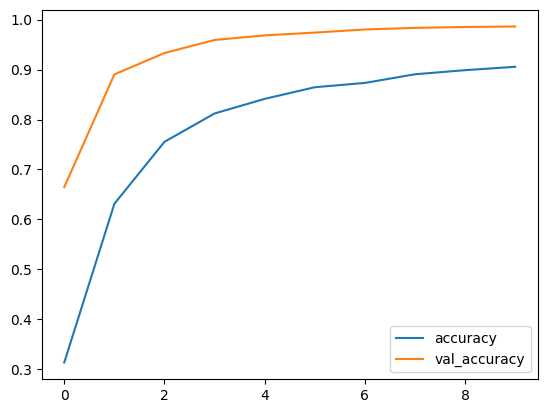

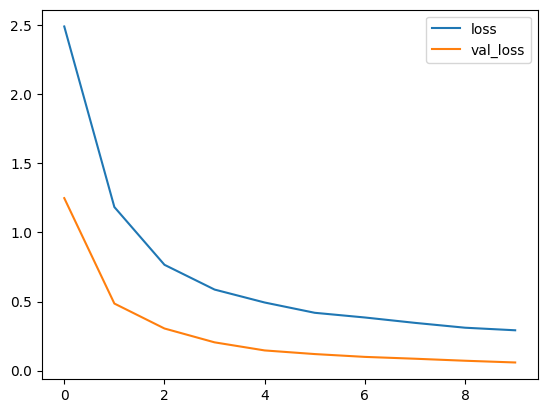

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

Selanjutnya, kita akan memvisualisasikan akurasi dan kerugian per epoch. Untuk ini, kita akan menyimpan riwayat model dalam dataframe pandas dan kemudian membuat grafiknya.








Membuat variabel yang berisi path dari dataset pengujian. Setelah mengunduh dataset, kami menemukan bahwa ada file GT-final_test.csv di folder gambar pengujian yang tidak dapat diproses. Oleh karena itu, kita akan menghapus file tersebut.








In [ ]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images

    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
    images = images/255

    return images

Langkah berikutnya adalah membuat fungsi untuk mengubah ukuran gambar uji, mengonversinya menjadi array numpy, dan menormalkan nilainya.

In [ ]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

Memanggil fungsi yang telah dibuat sebelumnya pada gambar uji.

In [ ]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

Selanjutnya, kita akan membaca ID label dari file Test.csv dan menyimpan nilai class ID ke dalam variabel y_test.








In [ ]:
# Mendapatkan probabilitas prediksi
predictions = model.predict(test_images)

# Mengambil indeks kelas dengan probabilitas tertinggi
y_pred = np.argmax(predictions, axis=1)

395/395 [==============================] - 12s 30ms/step


Sekarang kita akan menggunakan model untuk membuat prediksi pada gambar uji dan menyimpannya ke dalam variabel `y_pred`.

In [ ]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

Menyimpan label sesuai dengan kelas gambar.

Mari kita visualisasikan gambar uji.

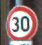

In [ ]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img

Mencari label asli untuk gambar di atas.

In [ ]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


Mencari Prediksi label untuk gambar di atas.

In [ ]:
# Predicted label
print("Predicted label : ",all_lables[y_pred[1]])

Predicted label :  Speed limit (30km/h)


## Conclusion:

Dalam proyek Traffic Sign Classification, kami berhasil mengunduh dan memproses dataset yang terdiri dari 43 kelas tanda lalu lintas. Setelah melakukan pra-pemrosesan data, kami membangun model Convolutional Neural Network (CNN) untuk klasifikasi gambar. Model ini dilatih selama 10 epoch dan menunjukkan peningkatan yang signifikan dalam akurasi.

Hasil pelatihan model:


Epoch 1: Akurasi: 31.34%, Akurasi Validasi: 66.46%

Epoch 10: Akurasi: 90.56%, Akurasi Validasi: 98.64%

Model mencapai akurasi 98.64% pada data validasi pada epoch terakhir, menunjukkan bahwa model mampu mengenali tanda lalu lintas dengan tingkat akurasi yang tinggi. Meskipun hasil ini sangat memuaskan, model masih dapat lebih ditingkatkan dengan melakukan hyperparameter tuning dan eksperimen dengan arsitektur yang lebih kompleks untuk mencapai akurasi yang lebih optimal.

Proyek ini membuktikan keterampilan saya dalam menggunakan deep learning untuk pemrosesan gambar dan klasifikasi, serta kemampuan dalam mengoptimalkan model untuk aplikasi dunia nyata seperti kendaraan otonom.

# Scope:

This model can be used in self driving cars which will enable them to automatically recognize traffic signs similarly the driver alert system inside cars will help and protect drivers by understanding the traffic signs around them.